In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import nan
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import copy
from tune_sklearn import TuneSearchCV
import scipy
from ray import tune

/usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# https://www.kaggle.com/arashnic/banking-loan-prediction
train = pd.read_csv('/content/drive/My Drive/project/train.csv')
test = pd.read_csv('/content/drive/My Drive/project/test.csv')

Dataset spitted to the train and test with following features:

    ID : Unique Customer ID

    Gender : Gender of the applicant

    DOB : Date of Birth of the applicant

    LeadCreationDate : Date on which Lead was created

    City_Code : Anonymised Code for the City

    City_Category: Anonymised City Feature

    Employer_Code: Anonymised Code for the Employer

    Employer_Category1 : Anonymised Employer Feature

    Employer_Category2: Anonymised Employer Feature

    Monthly_Income : Monthly Income in Dollars

    CustomerExistingPrimaryBankCode : Anonymised Customer Bank Code

    PrimaryBankType: Anonymised Bank Feature

    Contacted: Contact Verified (Y/N)

    Source : Categorical Variable representing source of lead

    Source_Category: Type of Source

    Existing_EMI : EMI of Existing Loans in Dollars

    Loan_Amount: Loan Amount Requested

    Loan_Period: Loan Period (Years)

    Interest_Rate: Interest Rate of Submitted Loan Amount

    EMI: EMI of Requested Loan Amount in dollars

    Var1: Anonymized Categorical variable with multiple levels

    Approved: (Target) Whether a loan is Approved or not (1-0) . Customer is Qualified Lead or not (1-0)


In [4]:
train

,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,Customer_Existing_Primary_Bank_Code,Primary_Bank_Type,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
0,APPC90493171225,Female,23/07/79,15/07/16,C10001,A,COM0044082,A,4.0,2000.0,B001,P,N,S122,G,0.0,NaN,NaN,NaN,NaN,0,0
1,APPD40611263344,Male,07/12/86,04/07/16,C10003,A,COM0000002,C,1.0,3500.0,B002,P,Y,S122,G,0.0,20000.0,2.0,13.25,953.0,10,0
2,APPE70289249423,Male,10/12/82,19/07/16,C10125,C,COM0005267,C,4.0,2250.0,B003,G,Y,S143,B,0.0,45000.0,4.0,NaN,NaN,0,0
3,APPF80273865537,Male,30/01/89,09/07/16,C10477,C,COM0004143,A,4.0,3500.0,B003,G,Y,S143,B,0.0,92000.0,5.0,NaN,NaN,7,0
4,APPG60994436641,Male,19/04/85,20/07/16,C10002,A,COM0001781,A,4.0,10000.0,B001,P,Y,S134,B,2500.0,50000.0,2.0,NaN,NaN,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69708,APPU90955789628,Female,31/07/83,30/09/16,C10006,A,COM0000010,A,1.0,4900.0,B002,P,N,S122,G,0.0,NaN,NaN,NaN,NaN,10,0
69709,APPV80989824738,Female,27/01/71,30/09/16,C10116,C,COM0045789,A,4.0,7190.1,B002,P,N,S122,G,1450.0,NaN,NaN,NaN,NaN,7,0
69710,APPW50697209842,Female,01/02/92,30/09/16,C10022,B,COM0013284,C,4.0,1600.0,B030,P,Y,S122,G,0.0,24000.0,4.0,35.50,943.0,2,0
69711,APPY50870035036,Male,27/06/78,30/09/16,C10002,A,COM0000098,C,3.0,9893.0,B002,P,Y,S122,G,1366.0,80000.0,5.0,NaN,NaN,10,0


In [5]:
def data_preprocessing(df):
  df.loc[(df['Gender'] == 'Female'), 'Gender'] = 0
  df.loc[(df['Gender'] != 0), 'Gender'] = 1

  df['DOB_year'] = nan
  df.loc[df['DOB'].notnull(), 'DOB_year'] = 121 - df['DOB'].loc[df['DOB'].notnull()].str[-2:].astype(int)
  df['DOB_year'] = df['DOB_year'].fillna(df['DOB_year'].median())

  df['Lead_Creation_Date'] = df['Lead_Creation_Date'].str.replace(r'(..\/..\/)(..)', r'\1 20\2')
  df['Lead_Creation_Date'] = pd.to_datetime(df['Lead_Creation_Date'], format="%d/%m/ %Y")
  df['Lead_Creation_Date_day'] = (df['Lead_Creation_Date']-pd.to_datetime('1/1/2016')).astype('timedelta64[h]')/24


  first_drop_cols = ['City_Code', 'Source', 'Customer_Existing_Primary_Bank_Code']
  for i in first_drop_cols:
    df[i] = df[i].loc[df[i].notnull()].str[1:].astype(int)
    df[i] = df[i].fillna(df[i].mode()[0])

  df['Employer_Code'] = df['Employer_Code'].loc[df['Employer_Code'].notnull()].str[3:].astype(int)
  df['Employer_Code'] = df['Employer_Code'].fillna(df['Employer_Code'].mode()[0])


  amount_cols = ['Employer_Category2', 'Monthly_Income', 'Existing_EMI', 'Loan_Amount',
               'Loan_Period', 'Interest_Rate', 'EMI', 'Var1'] 
  df[amount_cols] = df[amount_cols].fillna(df[amount_cols].median())


  str_cols = ['City_Category', 'Employer_Category1', 'Primary_Bank_Type', 'Contacted', 'Source_Category']
  str_dict = dict(enumerate(str_cols))
  for i in str_cols:
    df[i] = df[i].fillna(df[i].mode()[0])
  le = LabelEncoder()
  df[str_cols] = df[str_cols].apply(le.fit_transform)
  return df

In [6]:
train = data_preprocessing(train)
test = data_preprocessing(test)

In [7]:
not_float_cols = ['ID', 'DOB', 'Lead_Creation_Date']
train[train.columns.difference(not_float_cols)] = train[train.columns.difference(not_float_cols)].astype(float)

# посмотрим на данные и визуализируем их

In [8]:
train

,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,Customer_Existing_Primary_Bank_Code,Primary_Bank_Type,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved,DOB_year,Lead_Creation_Date_day
0,APPC90493171225,0.0,23/07/79,2016-07-15,10001.0,0.0,44082.0,0.0,4.0,2000.0,1.0,1.0,0.0,122.0,6.0,0.0,30000.0,4.0,18.00,941.0,0.0,0.0,42.0,196.0
1,APPD40611263344,1.0,07/12/86,2016-07-04,10003.0,0.0,2.0,2.0,1.0,3500.0,2.0,1.0,1.0,122.0,6.0,0.0,20000.0,2.0,13.25,953.0,10.0,0.0,35.0,185.0
2,APPE70289249423,1.0,10/12/82,2016-07-19,10125.0,2.0,5267.0,2.0,4.0,2250.0,3.0,0.0,1.0,143.0,1.0,0.0,45000.0,4.0,18.00,941.0,0.0,0.0,39.0,200.0
3,APPF80273865537,1.0,30/01/89,2016-07-09,10477.0,2.0,4143.0,0.0,4.0,3500.0,3.0,0.0,1.0,143.0,1.0,0.0,92000.0,5.0,18.00,941.0,7.0,0.0,32.0,190.0
4,APPG60994436641,1.0,19/04/85,2016-07-20,10002.0,0.0,1781.0,0.0,4.0,10000.0,1.0,1.0,1.0,134.0,1.0,2500.0,50000.0,2.0,18.00,941.0,10.0,0.0,36.0,201.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69708,APPU90955789628,0.0,31/07/83,2016-09-30,10006.0,0.0,10.0,0.0,1.0,4900.0,2.0,1.0,0.0,122.0,6.0,0.0,30000.0,4.0,18.00,941.0,10.0,0.0,38.0,273.0
69709,APPV80989824738,0.0,27/01/71,2016-09-30,10116.0,2.0,45789.0,0.0,4.0,7190.1,2.0,1.0,0.0,122.0,6.0,1450.0,30000.0,4.0,18.00,941.0,7.0,0.0,50.0,273.0
69710,APPW50697209842,0.0,01/02/92,2016-09-30,10022.0,1.0,13284.0,2.0,4.0,1600.0,30.0,1.0,1.0,122.0,6.0,0.0,24000.0,4.0,35.50,943.0,2.0,0.0,29.0,273.0
69711,APPY50870035036,1.0,27/06/78,2016-09-30,10002.0,0.0,98.0,2.0,3.0,9893.0,2.0,1.0,1.0,122.0,6.0,1366.0,80000.0,5.0,18.00,941.0,10.0,0.0,43.0,273.0


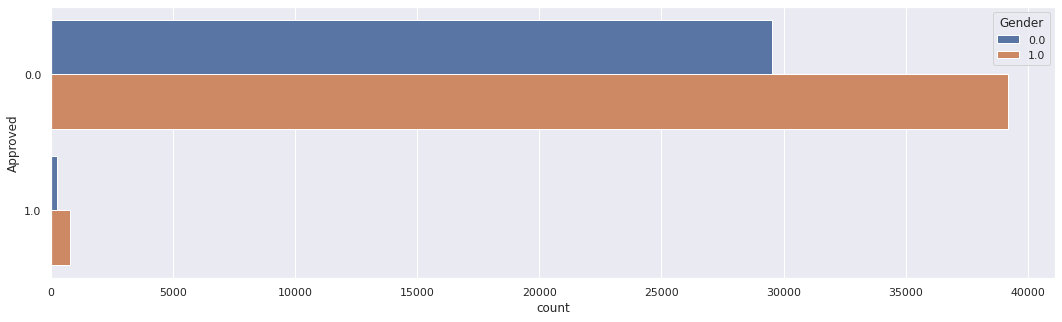

In [9]:
# количество утвержденных (1) и нет (0) заёмов в зависимости от пола
plt.figure(figsize=(18, 5)) 
sns.set_theme(style="darkgrid")
sns.countplot(y="Approved", hue="Gender", data=train)

можно сказать, что мужчины чаще подают заявку на заём

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-300.0, 13000.0)

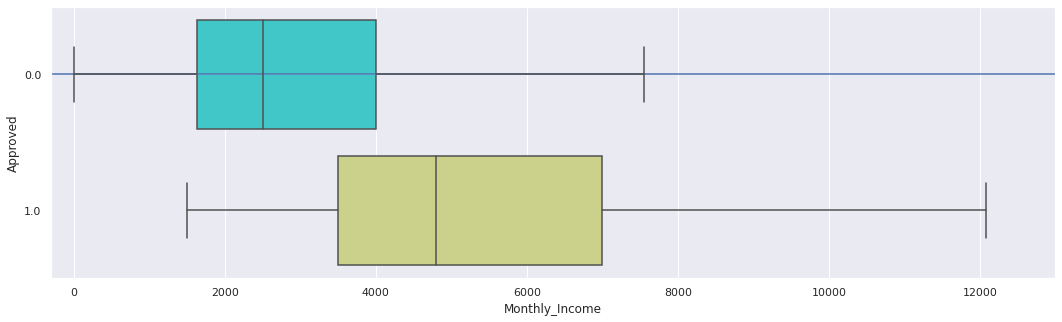

In [10]:
# распределение доходов у утвержденных (1) и нет (0) заёмов
plt.figure(figsize=(18, 5)) 
sns.distplot(train['Monthly_Income'])
sns.boxplot(x="Monthly_Income", y="Approved", data=train, showfliers=False, palette='rainbow', orient='h')
plt.xlim(-300, 13000)

медианный месячный доход у людей с утверждённым заёмом более чем на 2000 $ больше, чем у отклонённых

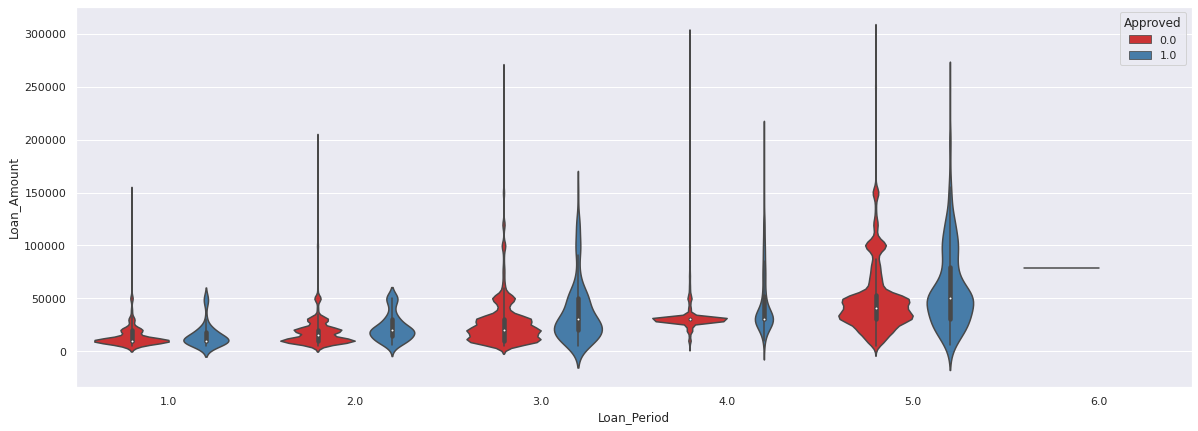

In [11]:
# распределение требуемых заёмов в зависимости от периода заёма у утвержденных (1) и нет (0) заёмов
plt.figure(figsize=(20, 7))
sns.violinplot(x="Loan_Period", y="Loan_Amount", data=train, palette='Set1', hue='Approved')

заметим, что распределение подтверждённых заёмов более нормальное. Это может быть связано с наличием определённых правил (формул) выдачи заёмов у банков

Text(0.5, 1.0, 'Тепловая карта корреляции')

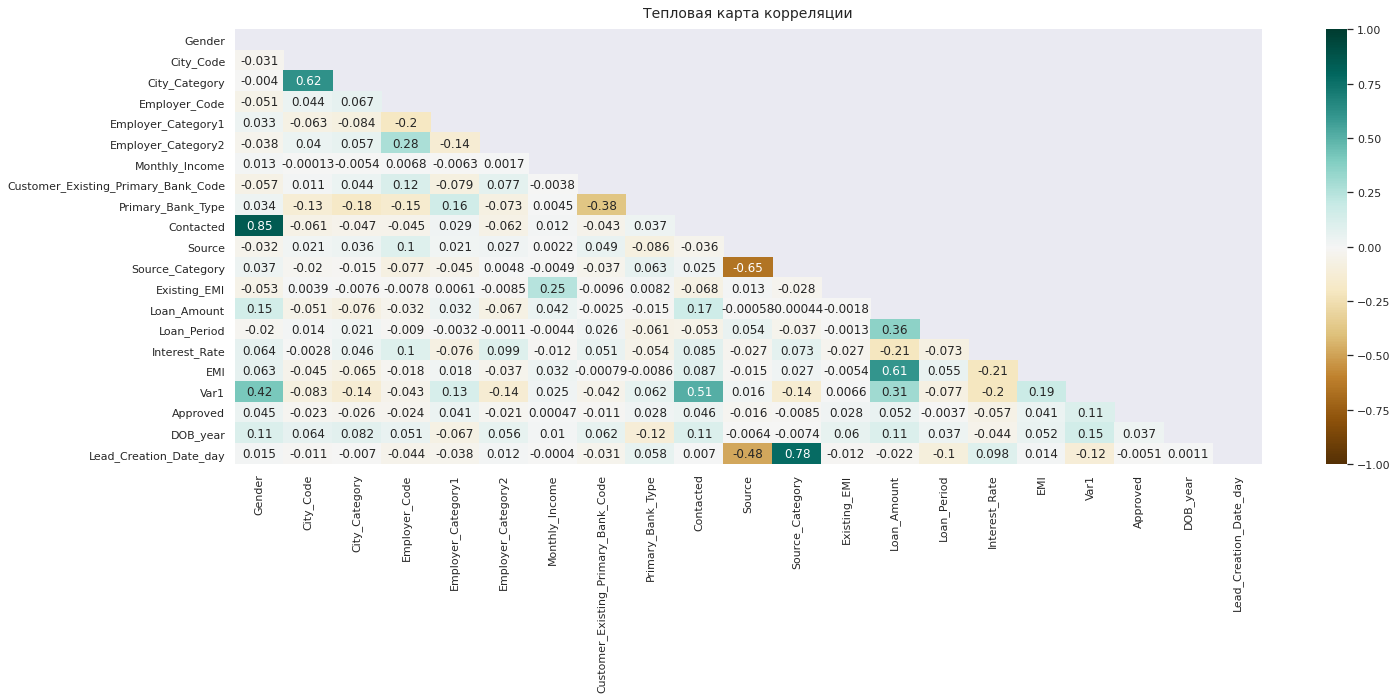

In [12]:
plt.figure(figsize=(23, 8)) 
mask = np.triu(np.ones_like(train.corr(), dtype=np.bool))
heatmap = sns.heatmap(train.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Тепловая карта корреляции', fontdict={'fontsize':14}, pad=12)

заметна наиболее выраженная положительная корреляция между Source_Category (тип канала рекламы) и Lead_Creation_Date_day (количество дней с начала 2016 года до даты создания запроса на заём)

C Approved (таргетом) наиболее связан Contacted, Loan_Amount и отрицательно Interest_Rate

# Начнём обучение модели

In [13]:
#уберём ненужные столбцы (личные или заменённые данные)
unused_cols = ['ID', 'DOB', 'Lead_Creation_Date']
train = train[train.columns.difference(unused_cols)].astype(float)

In [14]:
#проверим нет ли NaN в столбцах
for i in train.columns.difference(unused_cols):
  print('{} {}'.format(i, train[i].notnull().unique()))

Approved [ True]
City_Category [ True]
City_Code [ True]
Contacted [ True]
Customer_Existing_Primary_Bank_Code [ True]
DOB_year [ True]
EMI [ True]
Employer_Category1 [ True]
Employer_Category2 [ True]
Employer_Code [ True]
Existing_EMI [ True]
Gender [ True]
Interest_Rate [ True]
Lead_Creation_Date_day [ True]
Loan_Amount [ True]
Loan_Period [ True]
Monthly_Income [ True]
Primary_Bank_Type [ True]
Source [ True]
Source_Category [ True]
Var1 [ True]


In [12]:
#! pip install tune_sklearn

In [18]:
# посмотрим на количество строк с разными классами: датасет очень несбалансирован в сторону 0 (в около 68 раз)
train['Approved'].value_counts()

0.0    68693
1.0     1020
Name: Approved, dtype: int64

In [15]:
# отношение количества строк с 0 к 1 Approved
rat = len(train.loc[train['Approved']==0])//len(train.loc[train['Approved']==1])
rat

67

In [19]:
# создадим новый тренировочный датасет с одиноковым количеством 1 и 0, дублируя 1 rat раз (метод апсэмплинг)
# class_weight в модели не используем, так как отношение классов значительно больше 2-3
df_1 = train.loc[train['Approved']==1]
df_1 = df_1.loc[df_1.index.repeat(rat)]
train_n = pd.concat([train.loc[train['Approved']==0], df_1])

In [21]:
# делим на тренировочную и тестовую
X =  train_n[train_n.columns.difference(['Approved'])]
y = train_n['Approved']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# задаём параметры, из диапазона значений которых надо выбрать лучшее
# https://github.com/ray-project/tune-sklearn
param_dists = {
    'criterion': tune.choice(['gini', 'entropy']),
    'max_depth': tune.choice([i for i in range(2, 17)]),
    'max_features': tune.choice(['log2', 'sqrt']), 
    'min_samples_leaf': tune.choice([i for i in range(2, 33)]),
    'min_samples_split': tune.choice([i for i in range(2, 17)])
}

hyperopt_tune_search = TuneSearchCV(RandomForestClassifier(random_state=23),
    param_distributions=param_dists,
    n_trials=2,
    early_stopping=True,
    max_iters=10,
    search_optimization="hyperopt"
)

hts = hyperopt_tune_search.fit(X_train, y_train)

In [22]:
# значения метрик получились достаточно высокие (85+), что может говорить качественности модели классификации
y_pred = hts.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred))
print(roc_auc_score(y_test, y_pred, average='weighted'))

[[17180  3514]
 [  487 19929]]
(array([0.97243448, 0.85010451]), array([0.83019233, 0.97614616]), array([0.89570136, 0.90877585]), array([20694, 20416]))
0.9031692430763782


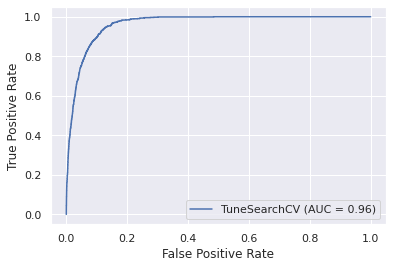

In [23]:
metrics.plot_roc_curve(hts, X_test, y_test)  
plt.show()  

# делаем предсказание для тестовых данных с соревнования

In [31]:
Y_test = hts.predict(test[test.columns.difference(unused_cols)].astype(float))

 ----------------------------------------------------------------------------------------------
 

# ЧЕРНОВОЕ. Первое 'грубое' обучение


In [78]:
df = copy.deepcopy(train)
unused_cols = ['ID', 'DOB', 'Lead_Creation_Date']
df = df[df.columns.difference(unused_cols)].astype(float)

In [79]:
# посмотрим на количество строк с разными классами: датасет очень несбалансирован в сторону 0 (в около 68 раз)
df['Approved'].value_counts()

0.0    68693
1.0     1020
Name: Approved, dtype: int64

In [80]:
# создадаи свою функцию случайного леса, где обучение будет происходить по batchам, где строк с 1 и 0 одинаково
# class_weight не используем, так как отношение классов згачительно больше 2-3
def imbalanced_rfc(df, test_size, target, batch_size, **args):
  df_1 = df.loc[df[target]==1]
  df_0 = df.loc[df[target]==0]
  clf = RandomForestClassifier(**args)
  len_df_0 = len(df_0)
  k = len_df_0 // batch_size
  for i in range(k-int(k*test_size)):
    df = pd.concat([df_0[i*(len_df_0 // k):(i+1)*(len_df_0 // k)], df_1.sample(n=(len_df_0 // k))])
    X = df[df.columns.difference([target])]
    y = df[target]
    clf.fit(X, y)
    clf.n_estimators += 1
  return clf, k, df_1, df_0, len_df_0

In [81]:
# подберём примерные гиперпараметры (для первого "грубого" обчуения)
batch_size = 32
test_size = 0.3
clf, k, df_1, df_0, len_df_0 = imbalanced_rfc(df=df, test_size=test_size, target='Approved', batch_size=batch_size, 
                     criterion='gini', max_depth=4, max_features= 'log2', 
                     min_samples_leaf=18, min_samples_split=2, n_estimators=1, random_state=23, warm_start=True)

df_test = pd.DataFrame()
for i in range((k-int(k*test_size)), k):
  df = pd.concat([df_0[i*(len_df_0//k):(i+1)*(len_df_0//k)], df_1.sample(n=(len_df_0//k))])
  df_test = pd.concat([df_test, df])
X_test = df_test[df.columns.difference(['Approved'])]
y_test = df_test['Approved']
y_pred = clf.predict(X_test)

In [82]:
# получаем не самые плохие метрики
print(confusion_matrix(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred))
print(roc_auc_score(y_test, y_pred, average='weighted'))

[[12514  8062]
 [ 3349 17227]]
(array([0.78887978, 0.68120527]), array([0.60818429, 0.83723756]), array([0.68684651, 0.75120462]), array([20576, 20576]))
0.7227109253499223


In [83]:
# Извлекаем значимость параметров
feat_importance = pd.DataFrame({'feature': list(X_test.columns),
                   'importance': clf.feature_importances_}).sort_values('importance', ascending = False)
# Выводим значения
feat_importance.head(clf.n_features_)

,feature,importance
15,Monthly_Income,0.197874
4,DOB_year,0.124285
8,Employer_Code,0.124285
19,Var1,0.111202
1,City_Code,0.102208
3,Customer_Existing_Primary_Bank_Code,0.076043
12,Lead_Creation_Date_day,0.062142
9,Existing_EMI,0.050695
18,Source_Category,0.036795
13,Loan_Amount,0.036795
